# Latent GAN

### Download dataset

https://github.com/NVlabs/ffhq-dataset

In [4]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('xhlulu/flickrfaceshq-dataset-nvidia-resized-256px', path='./datasets/ffhq256', unzip=True, quiet=False)

100%|██████████| 1.89G/1.89G [02:57<00:00, 11.4MB/s]


### Clone Latent Diffusion and download pretrained Autoencoders

https://github.com/CompVis/latent-diffusion

In [2]:
%pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
%pip install -e git+https://github.com/CompVis/latent-diffusion.git@main#egg=latent-diffusion

Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to c:\users\anton\downloads\latent-gan\src\taming-transformers
  Resolved https://github.com/CompVis/taming-transformers.git to commit 3ba01b241669f5ade541ce990f7650a3b8f65318
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for taming-transformers
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/CompVis/taming-transformers.git 'c:\Users\anton\Downloads\Latent-GAN\src\taming-transformers'


Obtaining latent-diffusion from git+https://github.com/CompVis/latent-diffusion.git@main#egg=latent-diffusion
  Cloning https://github.com/CompVis/latent-diffusion.git (to revision main) to c:\users\anton\downloads\latent-gan\src\latent-diffusion
  Resolved https://github.com/CompVis/latent-diffusion.git to commit a506df5756472e2ebaf9078affdde2c4f1502cd4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for latent-diffusion
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/CompVis/latent-diffusion.git 'c:\Users\anton\Downloads\Latent-GAN\src\latent-diffusion'


In [100]:
from utils.download import download_unpack

download_unpack('./pretrained/autoencoders', 'https://ommer-lab.com/files/latent-diffusion/vq-f4.zip')
download_unpack('./pretrained/autoencoders', 'https://ommer-lab.com/files/latent-diffusion/kl-f4.zip')

./pretrained/autoencoders/vq-f4 already exists
./pretrained/autoencoders/kl-f4 already exists


100%|██████████| 2.09G/2.09G [02:02<00:00, 18.2MB/s]


Unpacking ./pretrained/autoencoders/ffhq.zip
Done


### Visualize latent space

In [1]:
import torch
import torchvision
from tqdm import tqdm
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
import matplotlib.pyplot as plt

def imshow(x):
    if torch.is_tensor(x):
        array = x.detach().cpu().permute(0, 2, 3, 1).numpy()
    elif isinstance(x, list):
        array = x
    else:
        array = [x]
    for i in range(len(array)):
        plt.axis('off')
        plt.imshow(array[i])
        plt.show()

In [2]:
def load_model_from_config(config_path, ckpt_path):
    print(f'Loading model from {ckpt_path}')
    model = instantiate_from_config(OmegaConf.load(config_path).model)
    model.load_state_dict(torch.load(ckpt_path)['state_dict'], strict=False)
    model.cuda()
    model.eval()
    return model

model_kl = load_model_from_config(
    './src/latent-diffusion/models/first_stage_models/kl-f4/config.yaml', 
    './pretrained/autoencoders/kl-f4/model.ckpt'
)

#model_vq = load_model_from_config(
#    './src/latent-diffusion/models/first_stage_models/vq-f4/config.yaml', 
#    './pretrained/autoencoders/vq-f4/model.ckpt'
#)
     

Loading model from ./pretrained/autoencoders/kl-f4/model.ckpt
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [8]:
dataset = torchvision.datasets.ImageFolder(
    root='./datasets/ffhq256/',
    transform=torchvision.transforms.ToTensor()
)

In [9]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [10]:
model = model_kl

In [11]:
def encode(model, image):
    result = model.encode(image)
    if type(result) is tuple:
        result = result[0]
    else:
        result = result.mean
    return result.detach()

In [ ]:
min = torch.ones(3, dtype=torch.float32).cuda() * 1000
max = torch.ones(3, dtype=torch.float32).cuda() * -1000

for i, data in tqdm(enumerate(loader), total=len(loader)):
    image, labels = data
    L = encode(model, image.cuda())
    min = torch.minimum(min, L.amin(dim=(0, 2, 3)))
    max = torch.maximum(max, L.amax(dim=(0, 2, 3)))

In [26]:
print(min)
print(max)
torch.save(min, './datasets/kl-latent.min.pt')
torch.save(max, './datasets/kl-latent.max.pt')

tensor([-29.7389, -84.4269, -22.3829], device='cuda:0')
tensor([86.1855, 27.6609, 81.1055], device='cuda:0')


In [21]:
min = torch.load('./datasets/kl-latent.min.pt')
max = torch.load('./datasets/kl-latent.max.pt')

diff = (max - min)[:, None, None]
min = min[:, None, None]

  0%|                                                                                                                                                                                  | 0/70000 [00:00<?, ?it/s]

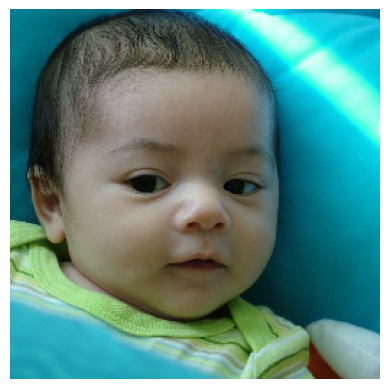

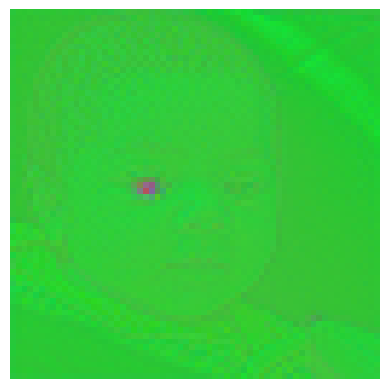

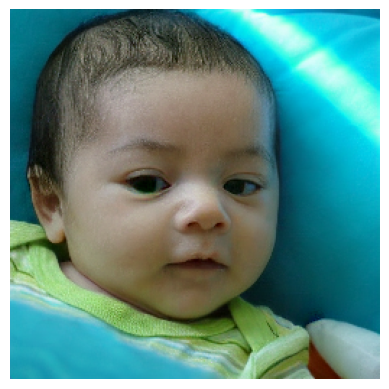

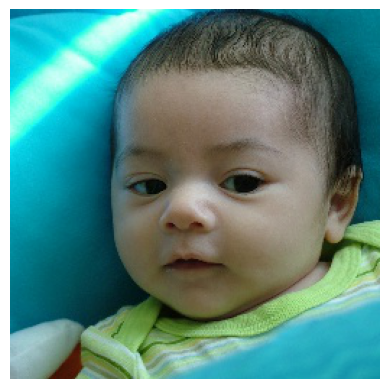

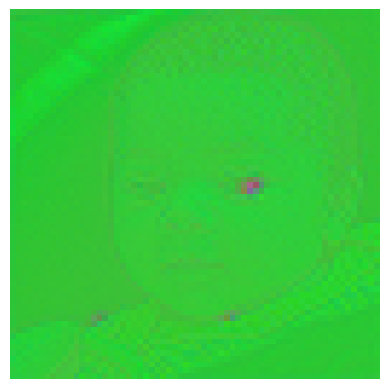

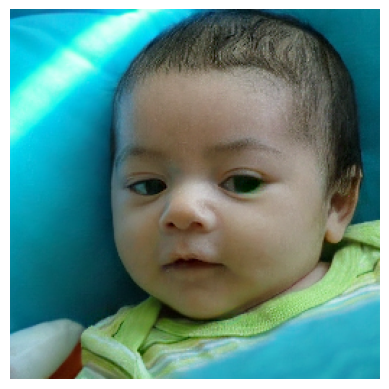

  0%|                                                                                                                                                                                  | 0/70000 [00:00<?, ?it/s]


In [26]:
for i, data in tqdm(enumerate(loader), total=len(loader)):
    image, labels = data
    imshow(image)

    L = encode(model, image.cuda())
    standardized = (L - min) / diff
    standardized = torch.clip(standardized, 0, 1)
    imshow(standardized)
    #torchvision.utils.save_image(standardized, f'./datasets/kl-latent/{i}_1.png')

    reconstructed = model.decode(L)
    reconstructed = torch.clip(reconstructed, 0, 1)
    imshow(reconstructed)
    
    image = torch.flip(image, (3,))
    imshow(image)
    
    L = encode(model, image.cuda())
    standardized = (L - min) / diff
    standardized = torch.clip(standardized, 0, 1)
    imshow(standardized)
    #torchvision.utils.save_image(standardized, f'./datasets/kl-latent/{i}_2.png')
    
    
    L = torchvision.transforms.ToTensor()(Image.open(f'./datasets/kl-latent/{i}_2.png')).cuda()[None, ...] * diff + min
    reconstructed = model.decode(L)
    reconstructed = torch.clip(reconstructed, 0, 1)
    imshow(reconstructed)
    
    
    break

### Run Stylegan 3

https://github.com/NVlabs/stylegan3

```
git clone https://github.com/NVlabs/stylegan3

python ./stylegan3/dataset_tool.py --source=./datasets/kl-latent --dest=./datasets/kl-latent.zip

python ./stylegan3/train.py --outdir=./training-runs --cfg=stylegan3-t --data=./datasets/kl-latent.zip --gpus=1 --batch=32 --batch-gpu=16 --snap=25 --gamma=0.125 --mirror=0 --aug=noaug
```

In [4]:
min = torch.load('./datasets/kl-latent.min.pt')
max = torch.load('./datasets/kl-latent.max.pt')

diff = (max - min)[:, None, None]
min = min[:, None, None]

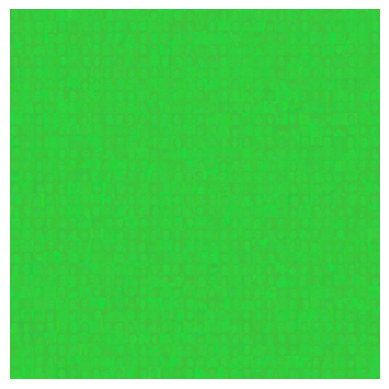

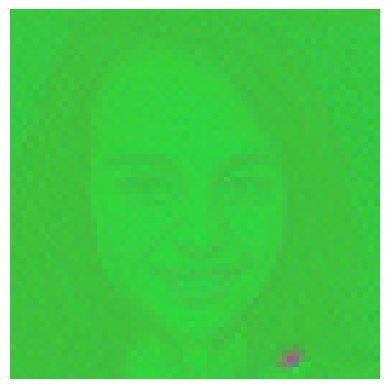

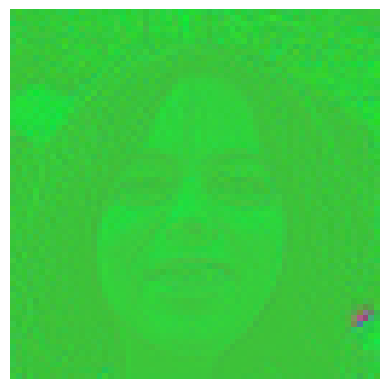

In [6]:
from PIL import Image

# Tensorflow - ma zaawansowany i bardzo wydajny pipeline do wczytywania plików
# Pytorch - nie potrafi sam wczytać obrazka

#grid = torchvision.transforms.ToTensor()(Image.open('./training-runs/00003-stylegan3-t-kl-latent-gpus1-batch32-gamma0.125/fakes000600.png'))
grid = torchvision.transforms.ToTensor()(Image.open('./training-runs/00003-stylegan2-kl-latent-gpus1-batch32-gamma0.0128/fakes000600.png'))
grid = torchvision.transforms.ToTensor()(Image.open('./training-runs/00007-stylegan3-t-kl-latent-gpus1-batch32-gamma0.125/fakes000800.png'))
imshow(grid[None, ...])
s = 64
images = [grid[:, x:x+s, y:y+s] for x in range(0, grid.shape[1], s) for y in range(0, grid.shape[2], s)]
imshow(torch.stack(images[0:2]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:11<00:00, 22.41it/s]


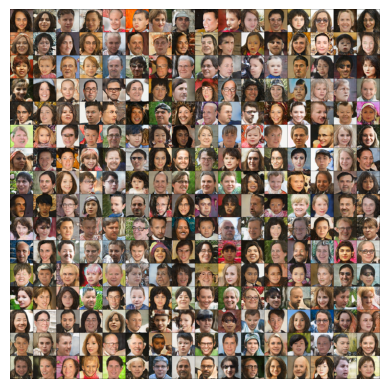

In [7]:
reconstructed_images = []
for image in tqdm(images[0:256]):
    L = image[None, ...].cuda() * diff + min
    reconstructed = model.decode(L).detach().cpu()
    reconstructed = torch.clip(reconstructed, 0, 1)
    reconstructed_images.append(reconstructed[0])
grid = torchvision.utils.make_grid(reconstructed_images, 16)
imshow(grid[None, ...])
torchvision.utils.save_image(grid, 'fakes000800 StyleGAN4 - rgb space.png')